In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# load and filter osm network (step 1)
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import time
import networkx as nx
import math
import osmnx as ox
import numpy as np
import pickle
import rasterio as rt
import shapely
import GOSTnets as gn
#import peartree

# Get reference to GOSTNets
import sys
sys.path.insert(1,"/Users/ccsuehara/GH_folders/GOSTnets/GOSTnets")
from fetch_pois import *
from core import *

#from load_osm import losm
## Can't seem to work https://stackoverflow.com/questions/62858552/why-cant-i-import-geopy-distance-vincenty-on-jupyter-notebook-i-installed-ge


from shapely.geometry import Point, box, Polygon
from shapely.ops import unary_union, linemerge, transform
from shapely.wkt import loads
from shapely import wkt
from shapely.geometry import LineString, MultiLineString, Point

#### Might not use these
import fiona
from osgeo import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob
import pygeos
import rtree
from more_utils import *

In [3]:
def classify_times(x):

    '''
    classsify penalty times according to how flooded a place is. 
    '''

    if x == -99999:
        y = 1
    if math.isnan(x):
        y = 1
    elif x <= 0:
        y = 1
    elif ((x > 0 ) & (x <= .1)):
        y = 2
    elif ((x > .1) & (x <= .25)):
        y = 5
    elif ((x > .25) & (x <= .35)):
        y = 5
    elif ((x > .35) & (x <= .5)):
        y = 9999       
    elif ((x > .35) & (x <= .5)):
        y = 9999
    elif x > .5:
        y = 9999

    return y

def clean_thing(x):
    '''
    cleans list into just a string. 
    takes either list or string, if its string it takes the second string element. 
    outputs the clean thing d
    '''
    if type(x) == list:
        a = x[0]
    else:
        a = x
    return a

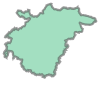

In [4]:
ashanti = gpd.read_file("/Users/ccsuehara/Documents/Ghana/data/ADM2_mat.shp")
ashanti = ashanti[ashanti['ADM1_NAME'] == "Ashanti"]
ashanti.set_crs('epsg:4326') 
ashanti = ashanti.dissolve(by = 'ADM1_NAME')
ashanti_bound = ashanti.geometry.iloc[0]
ashanti_bound.buffer(0)

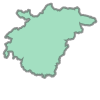

In [5]:
## Creating a buffer by first projecting into a coordinate system and then making the buffer
ashanti_2 = ashanti.copy()
ashanti_2 = ashanti_2.to_crs('epsg:25000')  
buffer_length_in_meters = (1000)
ashanti_2['geometry'] = ashanti_2.geometry.buffer(buffer_length_in_meters)
ashanti_2 = ashanti_2.to_crs('epsg:4326')  
ashanti_bound2 = ashanti_2.geometry.iloc[0]
ashanti_bound2.buffer(0)

In [6]:
adm2 = gpd.read_file("../data/GHA_ADM.gpkg", layer='GHA_ADM2')

In [7]:
ashanti_adm2 = adm2[adm2['ADM1_NAME'] == 'Ashanti'].copy()

<AxesSubplot:>

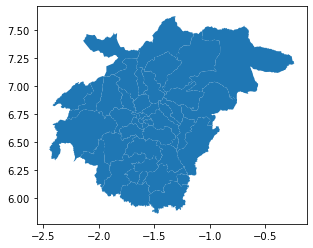

In [8]:
ashanti_adm2.plot()

In [119]:
#gDrive = ox.graph_from_polygon(ashanti_bound2, network_type= 'all', simplify=False, clean_periphery=False)
#gDrive = ox.project_graph(gDrive, to_crs='epsg:4326')

#gn.save(gDrive, '../data/Graphs/Ashanti', '', edges = True, nodes = True)

# If restarting, reload.
gDrivex = nx.read_gpickle("../data/Graphs/Ashanti.pickle")

gDrive_node_gdf__ = gn.node_gdf_from_graph(gDrivex)
gDrive_edge_gdf__ = gn.edge_gdf_from_graph(gDrivex)

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [120]:
gDrive_edge_gdf__.highway.value_counts(dropna = False)

residential       841165
unclassified      356083
tertiary          112823
track              37872
secondary          36431
path               22336
service            21450
primary            13207
trunk               9655
footway             4646
trunk_link           323
living_street        152
secondary_link       137
primary_link          57
tertiary_link         41
steps                 18
cycleway               6
pedestrian             2
Name: highway, dtype: int64

In [59]:
gDrive_edge_gdf['Wkt'] = gDrive_edge_gdf.geometry.to_wkt()



In [60]:
#Rebuild the graph once we added the Wkt field so we can later salt the road network. 
# gDrive_ = edges_and_nodes_gdf_to_graph(gDrive_node_gdf, gDrive_edge_gdf,
#                                         node_tag='node_ID',
#                                         u_tag='stnode', v_tag='endnode',
#                                         geometry_tag='geometry')

In [62]:
## The clean_network acts pretty strange and doesn't really work for making a real road network.
#Check the Ashanti cleaned road network to see what i mean 
#gDrive__ = gn.network_clean.clean_network(gDrive_)
##Currently running thissss 

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pandas/core/internals/construction.py:659: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  raw_lengths.append(len(val))
/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pandas/core/construction.py:588: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the leng

33976
33976
4721
7980
Edge reduction: 1456404 to 7980 (99 percent)


In [63]:
## Saving the simplified road network! 
gn.save(gDrive__, '../data/Graphs/Ashanti_cleaned', '', edges = True, nodes = True)

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### STEPS TO TAKE FOR CREATING THE FINAL ROAD NETWORK
1. create the graph. 
2. take the biggest strongly connected component ( list(gDrive.subgraph(c).copy() for c in nx.strongly_connected_components(gDrive)))
3. simplify graph  (ox.simplify_graph)
4. rebuild the roat network so it includes Wkt with edges_and_nodes_gdf_to_graph
5. salt_long_lines 

In [28]:
# list_of_subgraphs = list(gDrive.subgraph(c).copy() for c in nx.strongly_connected_components(gDrive))
# max_graph = None
# max_edges = 0
# for i in list_of_subgraphs:
#     if i.number_of_edges() > max_edges:
#         max_edges = i.number_of_edges()
#         max_graph = i

In [123]:
gDrive_s = max_graph.copy()
gDrive_s_node_gdf = gn.node_gdf_from_graph(gDrive_s)
gDrive_s_edge_gdf = gn.edge_gdf_from_graph(gDrive_s)

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [126]:
gDrive_ss =  ox.simplify_graph(gDrive_s)
gDrive_ss_node_gdf = gn.node_gdf_from_graph(gDrive_ss)
gDrive_ss_edge_gdf = gn.edge_gdf_from_graph(gDrive_ss)

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [130]:
gDrive_ss_edge_gdf.head(5)


,stnode,endnode,area,lanes,maxspeed,osmid,width,length,oneway,access,bridge,ref,junction,highway,name,tunnel,service,geometry,Wkt
0,330244260,3798598431,NaN,2,NaN,510553611,NaN,89.622,False,NaN,NaN,N8,NaN,trunk,NaN,NaN,NaN,"LINESTRING (-1.57239 6.45564, -1.57176 6.45512)","LINESTRING (-1.5723861 6.4556367, -1.5717594 6..."
1,330244260,3798595115,NaN,NaN,NaN,448168075,NaN,187.330,False,NaN,NaN,R104,NaN,secondary,NaN,NaN,NaN,"LINESTRING (-1.57239 6.45564, -1.57104 6.45667)","LINESTRING (-1.5723861 6.4556367, -1.5710449 6..."
2,330244260,3196999675,NaN,NaN,NaN,313684727,NaN,121.414,False,NaN,NaN,NaN,NaN,residential,NaN,NaN,NaN,"LINESTRING (-1.57239 6.45564, -1.57326 6.45497)","LINESTRING (-1.5723861 6.4556367, -1.5732599 6..."
3,330244260,1247775135,NaN,2,NaN,446896775,NaN,581.504,False,NaN,NaN,N8,NaN,trunk,NaN,NaN,NaN,"LINESTRING (-1.57239 6.45564, -1.57283 6.45592...","LINESTRING (-1.5723861 6.4556367, -1.5728339 6..."
4,3798598431,330244260,NaN,2,NaN,510553611,NaN,89.622,False,NaN,NaN,N8,NaN,trunk,NaN,NaN,NaN,"LINESTRING (-1.57176 6.45512, -1.57239 6.45564)","LINESTRING (-1.5717594 6.455125, -1.5723861 6...."


In [129]:
gDrive_ss_edge_gdf['Wkt'] = gDrive_ss_edge_gdf.geometry.to_wkt()

gDrivesss = edges_and_nodes_gdf_to_graph(gDrive_ss_node_gdf, gDrive_ss_edge_gdf,
                                        node_tag='node_ID',
                                        u_tag='stnode', v_tag='endnode',
                                        geometry_tag='geometry')


In [47]:
#gDrive2 = gn.network_clean.clean_network(gDrive)

In [131]:
#gDrive3 = gn.core.salt_long_lines(gDrivesss, 'epsg:4326','epsg:32638',thresh = 150, attr_list = ['length', 'highway'])

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

Identified 45596 unique edge(s) longer than 150. 
Beginning new node creation...
388894 new edges added and 90727 removed to bring total edges to 521489
148851 new nodes added to bring total nodes to 234307


#### First version 
Identified 68153 unique edge(s) longer than 100.   
Beginning new node creation...  
635888 new edges added and 135638 removed to bring total edges to 723572  
249791 new nodes added to bring total nodes to 335247

In [132]:
#gn.save(gDrive3, '../data/Graphs/Ashanti_clean_salted', '', edges = True, nodes = True)

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [9]:
# If restarting, reload.
gDrive3 = nx.read_gpickle("../data/Graphs/Ashanti_clean_salted.pickle")

In [10]:
df_dt = pd.DataFrame()
df_dt['place'] = ['Downtown']
df_dt['Lat'] = 6.6965673
df_dt['Lon'] = -1.6184545


geometry = [Point(xy) for xy in zip(df_dt.Lon, df_dt.Lat)]
df_dt = df_dt.drop(['Lon', 'Lat'], axis=1)
gdf_dt = GeoDataFrame(df_dt, crs="EPSG:4326", geometry=geometry)

gdf_dt.set_crs('epsg:4326')

,place,geometry
0,Downtown,POINT (-1.61845 6.69657)


In [11]:
gDrive_node_gdf = gn.node_gdf_from_graph(gDrive3)
gDrive_edge_gdf = gn.edge_gdf_from_graph(gDrive3)


/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
gDrive_edge_gdf['highway'] = gDrive_edge_gdf['highway'].apply(lambda x: clean_thing(x))

In [13]:
gDrive_edge_gdf.highway.value_counts(dropna = False)

residential       275747
unclassified      117331
tertiary           60720
secondary          21586
track              13930
primary             9543
trunk               8233
service             7436
path                5117
footway             1563
trunk_link           142
secondary_link        51
living_street         34
primary_link          25
tertiary_link         19
cycleway               6
steps                  4
pedestrian             2
Name: highway, dtype: int64

In [14]:
gDrive3_ = edges_and_nodes_gdf_to_graph(gDrive_node_gdf, gDrive_edge_gdf,
                                        node_tag='node_ID',
                                        u_tag='stnode', v_tag='endnode',
                                        geometry_tag='geometry')

In [15]:
speed_dict = {
                'residential': 40,  # kmph
                'primary': 80, 
                'primary_link':60,
                'trunk': 80,
                'trunk_link':60,
                'secondary': 70, 
                'secondary_link':50,
                'service': 40,
                'tertiary':60,
                'tertiary_link': 40,
                'unclassified':50, 
                'road':50,
                'track':25,
                'path':4.5,
                'cycleway':4.5,
    'steps': 4,
    'footway': 4,
    'living_street': 25
    

                }


In [16]:
gTime = gn.convert_network_to_time(gDrive3_, distance_tag = 'length', graph_type='drive', speed_dict = speed_dict)

In [17]:
gTime_node_gdf = gn.node_gdf_from_graph(gTime)
gTime_edge_gdf = gn.edge_gdf_from_graph(gTime)

/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [18]:
gTime_edge_gdf['fake_id'] = range(0, len(gTime_edge_gdf))

In [19]:
settlements = gpd.read_file('/Users/ccsuehara/Documents/Ghana/data/inter_regional/ashanti_settlements.shp').set_crs(epsg=4326)


In [20]:
gdf_settle = gn.pandana_snap_c(gTime, settlements,  add_dist_to_node_col = True)

In [21]:
lst_origins = list(gdf_settle['NN'].unique())

In [22]:
gdf_destination = gn.pandana_snap_c(gTime, gdf_dt,  add_dist_to_node_col = True) 

In [23]:
lst_destinations = list(gdf_destination['NN'].unique())

In [24]:
## These are flooding shapefiles which are product of the shell file called polygonize_Ashanti.sh,
#which transforms the merged plu+flu rasters to shapefiles.

path_shp = "../data/floods/Ashanti/merged/new/"

ev_5yr = gpd.read_file(path_shp + "ev_5.shp")
ev_10yr = gpd.read_file(path_shp +"ev_10.shp")
ev_20yr = gpd.read_file(path_shp +"ev_20.shp")
ev_50yr = gpd.read_file(path_shp +"ev_50.shp")
ev_100yr = gpd.read_file(path_shp +"ev_100.shp")
ev_200yr = gpd.read_file(path_shp +"ev_200.shp")


ev_5yr.crs = 'init=epsg:4326'
ev_10yr.crs = 'init=epsg:4326'
ev_20yr.crs = 'init=epsg:4326'
ev_50yr.crs = 'init=epsg:4326'
ev_100yr.crs = 'init=epsg:4326'
ev_200yr.crs = 'init=epsg:4326'

        


/Users/ccsuehara/opt/anaconda3/envs/test/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [25]:
#gTime_edge_gdf.highway.value_counts(dropna = False)
ev_5yr_d = ev_5yr.dissolve(by='DN', aggfunc='sum').reset_index()
#ev_50yr_d = ev_50yr.dissolve(by='DN', aggfunc='sum').reset_index()

In [26]:
edge_5yr = gpd.sjoin(gTime_edge_gdf, ev_5yr_d, how = "left", predicate = "within")
# edge_10yr = gpd.sjoin(gTime_edge_gdf, ev_10yr, how = "left")
# edge_20yr = gpd.sjoin(gTime_edge_gdf, ev_20yr, how = "left")
edge_50yr = gpd.sjoin(gTime_edge_gdf, ev_50yr, how = "left", predicate = "within")
#edge_100yr = gpd.sjoin(gTime_edge_gdf, ev_100yr, how = "left", predicate = "within")
# edge_200yr = gpd.sjoin(gTime_edge_gdf, ev_200yr, how = "left")

In [239]:
# ## Spatial indexes are not working :(
# gTime_edge_gdf_2 = gTime_edge_gdf.copy().reset_index(drop=True).to_crs('epsg:4326')
# ev_50yr_2 = ev_50yr.copy().reset_index(drop=True).to_crs('epsg:4326')

# spatial_index = gTime_edge_gdf_2.sindex
# possible_matches_index = list(spatial_index.intersection(ev_50yr_2.bounds))
# possible_matches = gTime_edge_gdf_2.iloc[possible_matches_index]
# precise_matches = possible_matches[possible_matches.intersects(ev_50yr_2)]

In [34]:
import time
start_time = time.time()

edge_miss = edge_5yr[edge_5yr['DN'].isna()].copy()['fake_id']
print("- %s segundos para paso 1 -" % (time.time() - start_time))

gdf = gTime_edge_gdf[gTime_edge_gdf['fake_id'].isin(edge_miss)].copy()
print("- %s segundos para paso 2 -" % (time.time() - start_time))

#missing = gpd.sjoin(gdf, ev_5yr_d, how = "left")
missing = pd.read_csv('../data/missing_5yr_edge.csv')

s = gpd.GeoSeries.from_wkt(missing['geometry'])
missing = GeoDataFrame(missing, crs="EPSG:4326", geometry= s) 
print("- %s segundos para paso 3 -" % (time.time() - start_time))


- 0.03274083137512207 segundos para paso 1 -
- 0.07551074028015137 segundos para paso 2 -
- 0.7089171409606934 segundos para paso 3 -


/var/folders/fw/9znznnm56pn2r_tnfxv4lcfc0000gn/T/ipykernel_967/2474184328.py:11: DtypeWarning: Columns (3,11,15,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  missing = pd.read_csv('../data/missing_5yr_edge.csv')


In [245]:
a = 497195 #notna
b = 24294 #isna
a + b

521489

In [46]:
a = edge_5yr[edge_5yr['DN'].notna()].copy()
a.shape
edge_5yr_final = gpd.GeoDataFrame( pd.concat( [a,missing], ignore_index=True) )

In [47]:
import time
start_time = time.time()

edge_miss2 = edge_50yr[edge_50yr['DN'].isna()].copy()['fake_id']
print("- %s segundos para paso 1 -" % (time.time() - start_time))
print(edge_miss2.shape, "shapeee of edgemiss")
gdf50 = gTime_edge_gdf[gTime_edge_gdf['fake_id'].isin(edge_miss2)].copy()
print("- %s segundos para paso 2 -" % (time.time() - start_time))

#missing50 = gpd.sjoin(gdf50, ev_50yr, how = "left")
missing50 = pd.read_csv('../data/missing_50yr_edge.csv')

s = gpd.GeoSeries.from_wkt(missing50['geometry'])
missing50 = GeoDataFrame(missing50, crs="EPSG:4326", geometry= s) 
print("- %s segundos para paso 3 -" % (time.time() - start_time))

- 0.24620580673217773 segundos para paso 1 -
(50072,) shapeee of edgemiss
- 0.3121809959411621 segundos para paso 2 -


/var/folders/fw/9znznnm56pn2r_tnfxv4lcfc0000gn/T/ipykernel_967/2836020813.py:11: DtypeWarning: Columns (3,10,11,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  missing50 = pd.read_csv('../data/missing_50yr_edge.csv')


- 1.377640962600708 segundos para paso 3 -


In [48]:
b = edge_50yr[edge_50yr['DN'].notna()].copy()
edge_50yr_final = gpd.GeoDataFrame( pd.concat( [b,missing50], ignore_index=True) )

In [49]:
## Eliminating edges that duplicate because of intersecting more than one flood geometry, and keeping the most flooded.

edge_5yr_final.sort_values('DN', inplace = True)
# edge_10yr.sort_values('DN', inplace = True)
# edge_20yr.sort_values('DN', inplace = True)
edge_50yr_final.sort_values('DN', inplace = True)
#edge_100yr.sort_values('DN', inplace = True)
# edge_200yr.sort_values('DN', inplace = True)


edge_5yr_final = edge_5yr_final[~edge_5yr_final.fake_id.duplicated(keep='last')]
# edge_10yr = edge_10yr[~edge_10yr.fake_id.duplicated(keep='last')]
# edge_20yr = edge_20yr[~edge_20yr.fake_id.duplicated(keep='last')]
edge_50yr_final = edge_50yr_final[~edge_50yr_final.fake_id.duplicated(keep='last')]
#edge_100yr = edge_100yr[~edge_100yr.fake_id.duplicated(keep='last')]
# edge_200yr = edge_200yr[~edge_200yr.fake_id.duplicated(keep='last')]

In [55]:

# for gdf in [edge_5yr, edge_10yr, edge_20yr, edge_50yr, edge_100yr, edge_200yr]:
for gdf in [edge_5yr_final,  edge_50yr_final]:
#     gdf['penalty_time'] =  (gdf['DN'].apply(lambda x: classify_times(x)))
    gdf['penalty_time'] = gdf['DN']
    gdf['time'] = gdf['time'] * gdf['penalty_time']


In [57]:
## Making different graphs for each flooding event:

gTime_5yr = edges_and_nodes_gdf_to_graph(gTime_node_gdf, edge_5yr_final,
                                        node_tag='node_ID',
                                        u_tag='stnode', v_tag='endnode',
                                        geometry_tag='geometry')


# gTime_10yr = edges_and_nodes_gdf_to_graph(gTime_node_gdf, edge_10yr,
#                                         node_tag='node_ID',
#                                         u_tag='stnode', v_tag='endnode',
#                                         geometry_tag='geometry')


# gTime_20yr = edges_and_nodes_gdf_to_graph(gTime_node_gdf, edge_20yr,
#                                         node_tag='node_ID',
#                                         u_tag='stnode', v_tag='endnode',
#                                         geometry_tag='geometry')

gTime_50yr = edges_and_nodes_gdf_to_graph(gTime_node_gdf, edge_50yr_final,
                                        node_tag='node_ID',
                                        u_tag='stnode', v_tag='endnode',
                                        geometry_tag='geometry')
# gTime_100yr = edges_and_nodes_gdf_to_graph(gTime_node_gdf, edge_100yr,
#                                         node_tag='node_ID',
#                                         u_tag='stnode', v_tag='endnode',
#                                         geometry_tag='geometry')

# gTime_200yr = edges_and_nodes_gdf_to_graph(gTime_node_gdf, edge_200yr,
#                                         node_tag='node_ID',
#                                         u_tag='stnode', v_tag='endnode',
#                                         geometry_tag='geometry')

In [58]:
fail_value = 999999999
OD_base = gn.calculate_OD(gTime, lst_origins, lst_destinations, fail_value, weight = 'time')
OD_5yr = gn.calculate_OD(gTime_5yr, lst_origins, lst_destinations, fail_value, weight = 'time')
OD_50yr = gn.calculate_OD(gTime_50yr, lst_origins, lst_destinations, fail_value, weight = 'time')

In [59]:
OD_df_b = pd.DataFrame(OD_base, index = lst_origins, columns = lst_destinations)
OD_df_5yr = pd.DataFrame(OD_5yr, index = lst_origins, columns = lst_destinations)
OD_df_50yr = pd.DataFrame(OD_50yr, index = lst_origins, columns = lst_destinations)

In [60]:
def create_poi_and_df(list_points, df, name_col):

    '''
    create closest travel time to destination for each origin 
    list_points: list of a single kind of destinagion, eg markets. 

    df: OD matrix as a dataframe
    '''
    fail_value = 999999999

    result_df = df.loc[:, list_points]
    result_df = result_df[result_df < fail_value] / 60
    result_df[name_col] = 0
    sub = result_df.iloc[:,0:-1]
    result_df[name_col] = sub.min(axis = 1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
    # We can take the mean, or the max value, let's check that. 
    new_df = result_df[[name_col]]
    new_df['NN'] = new_df.index
    return new_df

In [61]:
key = 'downtown'
OD_to_dest_b = create_poi_and_df(lst_destinations, OD_df_b, key)
OD_to_dest_5y = create_poi_and_df(lst_destinations, OD_df_5yr, key)
OD_to_dest_50y = create_poi_and_df(lst_destinations, OD_df_50yr, key)




In [62]:
newdic = {'base': OD_to_dest_b, '5yr': OD_to_dest_5y, '50yr': OD_to_dest_50y}

In [63]:
new_df = pd.DataFrame()
new_df['NN'] = gdf_settle.NN.unique()
for key, df in newdic.items():
    new_df = new_df.merge(df, on = 'NN', how = 'left')
    new_df.rename(columns = {'downtown': key }, inplace = True)
    



Ashanti_access = gdf_settle.merge(new_df, on= 'NN', how = "left")




In [65]:
final_Ashanti = calculate_indicators(Ashanti_access, ['5yr', '50yr'], 'population')

In [66]:
final_Ashanti


,fid,ADM2_CODE,ADM2_NAME,ADM1_CODE,ADM1_NAME,ADM0_CODE,ADM0_NAME,STATUS,DISP_AREA,OBJECTID,...,dtime_5yr_t,trunc_5yr,bins_5yr,dtime_50yr,worse_50yr,iso1day_50yr,iso2day_50yr,dtime_50yr_t,trunc_50yr,bins_50yr
0,35.0,190567.0,Afigya Kwabre North,1324.0,Ashanti,94.0,Ghana,Member State,NO,110951,...,1.616650e+07,1440.000000,288,877343.680313,60.597786,60.597786,60.597786,5.316508e+07,1440.0,288
1,218.0,16566.0,Afigya Kwabre South,1324.0,Ashanti,94.0,Ghana,Member State,NO,110951,...,1.616650e+07,1440.000000,288,877343.680313,60.597786,60.597786,60.597786,5.316508e+07,1440.0,288
2,35.0,190567.0,Afigya Kwabre North,1324.0,Ashanti,94.0,Ghana,Member State,NO,110952,...,5.788376e+07,1440.000000,288,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
3,35.0,190567.0,Afigya Kwabre North,1324.0,Ashanti,94.0,Ghana,Member State,NO,110953,...,9.305747e+06,1440.000000,288,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
4,35.0,190567.0,Afigya Kwabre North,1324.0,Ashanti,94.0,Ghana,Member State,NO,110954,...,2.459843e+07,1440.000000,288,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53964,239.0,19.0,Juaben Municipal,1324.0,Ashanti,94.0,Ghana,Member State,NO,121807,...,0.000000e+00,60.440453,13,27102.013859,8.734902,8.734902,8.734902,2.367334e+05,1440.0,288
53965,239.0,19.0,Juaben Municipal,1324.0,Ashanti,94.0,Ghana,Member State,NO,121808,...,8.466656e+01,102.061617,21,24928.870903,8.683751,8.683751,8.683751,2.164761e+05,1440.0,288
53966,239.0,19.0,Juaben Municipal,1324.0,Ashanti,94.0,Ghana,Member State,NO,121809,...,2.844407e+02,143.872803,29,98736.015181,7.224120,7.224120,7.224120,7.132808e+05,1440.0,288
53967,239.0,19.0,Juaben Municipal,1324.0,Ashanti,94.0,Ghana,Member State,NO,121811,...,1.720207e+02,97.340187,20,27147.375181,16.019365,16.019365,16.019365,4.348837e+05,1440.0,288


In [332]:
#missing.to_csv('../data/missing_5yr_edge.csv')
#missing50.to_csv('../data/missing_50yr_edge.csv')